# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [181]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

import numpy as np
import matplotlib.pyplot as plt
#下面的`scipy`是一个用于科学计算和技术计算的Python库，提供了许多高级的数学函数和便利的操作，包括数值积分、插值、优化、图像处理、统计等。
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）。
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。
from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
from mpl_toolkits.mplot3d import Axes3D #`mpl_toolkits.mplot3d`是`matplotlib`库的一个模块，用于创建三维图形。`Axes3D`是`mpl_toolkits.mplot3d`模块中的一个类，用于创建一个三维的坐标轴。可以在这个坐标轴上绘制三维的图形，如曲线、曲面等。
import time #一个内置模块，用于处理时间相关的操作。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。

import math
import pandas as pd #pandas用于处理结构化数据
from scipy.io import savemat #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

import random

from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。




# torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

In [182]:
# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [183]:

# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers,gamma,num_of_GP): #初始化函数，layers是一个列表，表示每一层的神经元个数，gamma是GP的参数，num_of_GP是GP的参数
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        self.num_of_GP = num_of_GP #定义名为num_of_GP的属性，表示GP的参数
        self.gamma = gamma #定义名为gamma的属性，表示GP的参数
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(self.num_of_GP, layers[-1], bias=False))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    

        # Initialize weights
        self._initialize_weights()  

        # # Initialize beta for the output layer
        # self.beta = torch.nn.Parameter(torch.randn(layers[-1], 1))  # 初始化回归权重矩阵beta

        # Initialize GP_W and GP_b
        self.GP_W = torch.randn(layers[-2], self.num_of_GP) * math.sqrt(2 * self.gamma)  # 初始化GP_W
        self.GP_b = torch.rand(1, self.num_of_GP) * 2 * math.pi  # 初始化GP_b

    def _initialize_weights(self):
        for idx, m in enumerate(self.layers): #遍历神经网络模型的每一层，获取每一层的索引idx和层对象m(注意这里idx会包括激活函数，也占一个idx)
            if isinstance(m, torch.nn.Linear): #判断层对象m是否是全连接层

                # 自定义初始化函数
                fan_in = m.weight.size(0)  # 输入单元数量
                fan_out = m.weight.size(1)  # 输出单元数量
                std = (2 / (fan_in + fan_out)) ** 0.5  # 计算标准差
                
                with torch.no_grad():
                    m.weight.normal_(0, std)  # 使用自定义标准差初始化权重
                if m.bias is not None: #若存在偏置
                    torch.nn.init.zeros_(m.bias) #使用常数初始化方法初始化偏置，初始化为0
                
                # 归一化权重
                if idx > 0 and idx < len(self.layers) - 2: #不归一化输入层、输出层和最后一个隐藏层
                #注意这里其实idx包含了激活函数，例如对于[1,50,50,50,50,1]，这里共有6层，但是idx应该是9，因为四个隐藏层+四个激活函数+输出层。所以因为idx0是全连接层，最后一个idx为输出层，因此这样做是可以剔除第一个权重和最后一个权重的
                    with torch.no_grad(): #确保归一化过程中不进行梯度计算
                        norm = m.weight.norm(2) #计算该层权重的二范数
                        if norm > 0.99: #若二范数大于0.99
                            m.weight.mul_(0.99 / norm) #将权重乘以0.99/norm，使得二范数等于0.99
    
    #第二个方法，前向传播
    def forward(self, X, lb, ub):  # 接收输入x
        device = X.device  # 获取输入张量的设备
        self.GP_W = self.GP_W.to(device)  # 将GP_W移动到相同设备
        self.GP_b = self.GP_b.to(device)  # 将GP_b移动到相同设备
        H = 2.0*(X - lb)/(ub - lb) - 1.0 #这里H是X经过归一化处理后的结果，将X映射到了[-1,1]区间内
        #第一层
        H = self.layers[0](H)
        H = self.layers[1](H)

        # 中间隐藏层
        for i in range(2, len(self.layers) - 2, 2):  # 循环遍历中间隐藏层
            with torch.no_grad():
                norm = self.layers[i].weight.norm(2)
                if norm > 0.99:
                    self.layers[i].weight.mul_(0.99 / norm)
            # H = self.layers[i+1](self.layers[i](H))
            H_1 = self.layers[i+1](self.layers[i](H))  # 计算输出并加上偏置(i+1是激活函数，i是全连接层)
            # H = H + H_1  # 加上前一层的输出构成本层新的输出
            # H = H.clone() + H_1

        # 在最后一个隐藏层和输出层之间添加一层
        H1 = torch.matmul(H, self.GP_W) + self.GP_b  # 计算H1
        Fai = math.sqrt(2 / self.num_of_GP) * torch.cos(H1)  # 计算Fai
        H = Fai  # 更新H为Fai

        # 输出层
        out = self.layers[-1](H)  # 计算输出
        return out  # 返回输出out
    
    #第三个方法，获取hidden输出
    def dnn_for_hidden_features(self, X, lb, ub):  # 接收输入x
        H = 2.0*(X - lb)/(ub - lb) - 1.0 #这里H是X经过归一化处理后的结果，将X映射到了[-1,1]区间内
        #第一层
        H = self.layers[0](H)
        H = self.layers[1](H)

        # 中间隐藏层
        for i in range(2, len(self.layers) - 2, 2):  # 循环遍历中间隐藏层
            with torch.no_grad():
                norm = self.layers[i].weight.norm(2)
                if norm > 0.99:
                    self.layers[i].weight.mul_(0.99 / norm)
            # H = self.layers[i+1](self.layers[i](H))
            H_1 = self.layers[i+1](self.layers[i](H))  # 计算输出并加上偏置(i+1是激活函数，i是全连接层)
            # H = H + H_1  # 加上前一层的输出构成本层新的输出
            # H = H.clone() + H_1 # 加上前一层的输出构成本层新的输出

        # 在最后一个隐藏层和输出层之间添加一层
        H1 = torch.matmul(H, self.GP_W) + self.GP_b  # 计算H1
        Fai = math.sqrt(2 / self.num_of_GP) * torch.cos(H1)  # 计算Fai

        return H, Fai  # 返回输出out
    
    

In [186]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self,x0, u0, tb, X_f, layers, lb, ub, gamma, num_of_GP): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
    
        self.gamma = gamma
        self.num_of_GP = num_of_GP


        #`numpy.concatenate`是一个用于数组拼接的函数。它可以将多个数组沿指定的轴拼接在一起，形成一个新的数组：numpy.concatenate((a1,a2, ...), axis=0)其中，`a1,a2, ...`是需要拼接的数组（只能接受数组或序列类型的参数，且参数形状必须相同），可以是多个。`axis`参数用于指定拼接的轴向，`axis=0`表示沿着第一个轴（即行）进行拼接，不指定`axis`参数默认值是0。
        X0 = np.concatenate((x0,0*x0), 1) # [x0, 0],将x0和0*x0两个数组在第二个维度（即列）上进行了合并。0*x0会生成一个与x0形状相同，但所有元素都为0的数组。因此，X0的结果是一个新的二维数组，其中第一列是x0的值，第二列全为0
        X_lb = np.concatenate((0*tb+lb[0],tb), 1) # [lb[0], tb],将0*tb+lb[0]和tb两个数组在第二个维度（即列）上进行了合并。0*tb+lb[0]会生成一个与tb形状相同，但所有元素都为lb[0]的数组。因此，X_lb的结果是一个新的二维数组，其中第一列全为lb[0]的值，第二列是tb的值。
        X_ub = np.concatenate((0*tb+ub[0],tb), 1) # [ub[0], tb],同上生成一个与tb形状相同，但所有元素都为ub[0]的数组。因此，X_ub的结果是一个新的二维数组，其中第一列全为ub[0]的值，第二列是tb的值
        
        #boundary conditions
        #Python使用self关键字来表示类的实例。当在类的方法中定义一个变量时，例如lb和ub，这些变量只在该方法内部可见，也就是说它们的作用域仅限于该方法。当方法执行完毕后，这些变量就会被销毁，无法在其他方法中访问它们。但如果希望在类的其他方法中也能访问这些变量就需要将它们保存为类的实例属性。这就是self.lb和self.ub的作用。
        #通过将lb和ub赋值给self.lb和self.ub，就可以在类的其他方法中通过self.lb和self.ub来访问这些值。总的来说，self.lb和self.ub是类的实例属性，它们的作用域是整个类，而不仅仅是定义它们的方法。
        self.lb = torch.tensor(lb).float().to(device) #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.ub = torch.tensor(ub).float().to(device)        


        self.x0 = torch.tensor(X0[:,0:1], requires_grad=True).float().to(device) #将X0的第一列赋值给self.x0（:表示取所有行,0：1实际上表示取第一列，因为python是左闭右开的）,将X0的第二列赋值给self.t0。这样可以在类的其他方法中通过self.x0和self.t0来访问这些值。
        self.t0 = torch.tensor(X0[:,1:2], requires_grad=True).float().to(device) #将x0的第二列赋值给self.t0

        self.x_lb = torch.tensor(X_lb[:,0:1], requires_grad=True).float().to(device) #将X_lb的第一列赋值给self.x_lb
        self.t_lb = torch.tensor(X_lb[:,1:2], requires_grad=True).float().to(device) #将X_lb的第二列赋值给self.t_lb

        self.x_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第一列赋值给self.x_ub
        self.t_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第二列赋值给self.t_ub
        
        self.x_f = torch.tensor(X_f[:,0:1], requires_grad=True).float().to(device) #将X_f的第一列赋值给self.x_f
        self.t_f = torch.tensor(X_f[:,1:2], requires_grad=True).float().to(device) #将X_f的第二列赋值给self.t_f
        
        self.u0 = torch.tensor(u0).float().to(device) #将传入的u0和v0参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u0和self.v0来访问这些值。        


        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers,gamma,num_of_GP).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-5,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        self.iter = 0 #记录迭代次数 
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1),self.lb,self.ub)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u

    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        mu = 1/(1*np.pi**2)
        f =-1*u_t + mu * u_xx #定义见论文

        return f
    # def net_f_u(self,x):
    #     u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        
    #     #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
    #     u_x = torch.autograd.grad(
    #         u, x,  #输入的张量，要计算u关于t的导数
    #         grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
    #         retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
    #         create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
    #     )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

    #     PI = np.pi
    #     u_xx = torch.autograd.grad(
    #         u_x, x, 
    #         grad_outputs=torch.ones_like(u_x),
    #         retain_graph=True,
    #         create_graph=True
    #     )[0]

    #     fx = -1*PI**2*torch.sin(PI*x)-PI*torch.cos(PI*x)*(torch.sin(PI*x))**2 #计算f(x)的值
    #     m_loss =  u_xx-u**2 *u_x -fx #计算损失函数
        
    #     return m_loss #返回损失函数


    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u0_pred = self.net_u(self.x0, self.t0) #调用之前定义的函数，传入参数得到神经网络的输出u
        u_lb_pred = self.net_u(self.x_lb, self.t_lb) #调用之前定义的函数，传入参数得到神经网络的输出u
        u_ub_pred = self.net_u(self.x_ub, self.t_ub) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
    


        loss = torch.mean((self.u0 - u0_pred) ** 2) + \
                torch.mean((u_lb_pred) ** 2) + \
                torch.mean((u_ub_pred) ** 2) + \
                torch.mean(f_pred ** 2) #计算损失函数
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e' % (self.iter, loss.item()) 
            ) #每100次迭代，打印一次迭代次数、总的loss、loss_u和loss_f
        return loss #返回总的loss
    
    # def train(self, nIter, nIterLBFGS):
    def train(self, nIter):
        self.dnn.train() #将神经网络设置为训练模式而不是评估模式
        
        # # 初始化一个列表来存储每个epoch的权重矩阵
        # self.weights = []   

        #使用Adam优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='Adam'):
        for epoch in range(nIter):
            u0_pred = self.net_u(self.x0, self.t0) #调用之前定义的函数，传入参数得到神经网络的输出u
            u_lb_pred = self.net_u(self.x_lb, self.t_lb) #调用之前定义的函数，传入参数得到神经网络的输出u
            u_ub_pred = self.net_u(self.x_ub, self.t_ub) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        


            loss = torch.mean((self.u0 - u0_pred) ** 2) + \
                   torch.mean((u_lb_pred) ** 2) + \
                   torch.mean((u_ub_pred) ** 2) + \
                   torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            # #record the loss value
            # self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 记录每一层的权重矩阵
            # epoch_weights = []
            # for layer in self.dnn.layers:
            #     if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
            #         epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            # self.weights.append(epoch_weights)

            # W = self.weights

            # for i in tqdm(range(1), desc='LBFGS'):
            #     self.optimizer_LBFGS.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    
    
    def net_for_hidden_features(self, X):
        self.dnn.eval() #将神经网络切换为评估模式
        # x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        X = torch.tensor(X, requires_grad=True).float().to(device)
        H,Fai = self.dnn.dnn_for_hidden_features(X, self.lb, self.ub)
        H = H.detach().cpu().numpy()
        Fai = Fai.detach().cpu().numpy()
        return H,Fai




    # def hidden_predict(self, x,t):
    #     x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
    #     t = torch.tensor(t, requires_grad=True).float().to(device)
    #     self.dnn.eval()
    #     hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
    #     hidden_output_x = hidden_output[:, 0]
    #     hidden_output_t = hidden_output[:, 1]
    #     hidden_output_x = hidden_output_x.detach().cpu().numpy()
    #     hidden_output_t = hidden_output_t.detach().cpu().numpy()
    #     return hidden_output_x, hidden_output_t

In [187]:
noise = 0.0        
    
# Doman bounds
lb = np.array([-1.0, 0.0]) #  spatial time
ub = np.array([1.0, 1.0])  # spatial time

N0 = 20
N_b = 20
N_f = 200
gamma = 5.0
num_of_GP = 1024
layers = [2,  100, 100, 100,100,1]

t = np.linspace(lb[1],ub[1],101)
t =t.flatten()[:,None]
x = np.linspace(lb[0],ub[0],101)
x =x.flatten()[:,None]
X, T = np.meshgrid(x,t)
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

idx_x = np.random.choice(x.shape[0], N0, replace=False) # index to use for initial conditions
x0 = x[idx_x,:] # The value of x under initial conditions
u0 = np.sin(np.pi*x0)

idx_t = np.random.choice(t.shape[0], N_b, replace=False) # Index used for boundary conditions
tb = t[idx_t,:]   
X_f = lb + (ub-lb)*lhs(2, N_f)

data = scipy.io.loadmat('collocationpoint.mat')  

X_f = data['collocationpoint']  
x0 = X_f[0:20,0:1]
u0 = np.sin(np.pi*x0)
tb = X_f[20:40,1:2]
X_f = X_f[60:X_f.shape[0],:]  # In order to be consistent with the previous results

In [189]:
model = PhysicsInformedNN(x0, u0, tb, X_f, layers, lb, ub, gamma, num_of_GP)

start_time = time.time()               
model.train(5000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))   

Training time: 34.0516


In [190]:
# 训练时，所用的数据集X_know
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_know = np.concatenate((X0, X_lb, X_ub, X_f),0) # X_know the corresponding predicted value
u_pred, f_u_pred = model.predict(X_know)
f_know = u_pred

In [191]:
print(X_know.shape)
# print(X_know)
print(u_pred.shape)
# print(u_pred)
print(f_u_pred.shape)
# print(f_u_pred)


(160, 2)
(160, 1)
(160, 1)


In [192]:
u_pred, f_u_pred = model.predict(X_star)
prediction_all = u_pred

In [193]:
print(u_pred.shape)
print(u_pred)
print(f_u_pred.shape)

(10201, 1)
[[-0.00111873]
 [-0.06307341]
 [-0.12512812]
 ...
 [ 0.04929362]
 [ 0.02477126]
 [ 0.00019476]]
(10201, 1)


In [196]:
# Hidden layer of X_konw
Hidden_pred_small, Fai_pred_small = model.net_for_hidden_features(X_know)
X = Hidden_pred_small
hidden_feat_know = Fai_pred_small

In [197]:
print(Hidden_pred_small.shape)
print(Hidden_pred_small)
print(Fai_pred_small.shape)
print(Fai_pred_small)

(160, 100)
[[ 0.09789358  0.06752193 -0.1863276  ...  0.13435858 -0.12611647
  -0.00813236]
 [-0.00876809 -0.06935801 -0.4669123  ...  0.11818742 -0.06249155
  -0.0398675 ]
 [ 0.16823809  0.15810288  0.02415959 ...  0.1451495  -0.16818698
   0.01313455]
 ...
 [-0.08393859 -0.14415373 -0.22572523 ... -0.04072717  0.0306245
   0.01741297]
 [-0.08091997 -0.1383032  -0.16933952 ... -0.05491631  0.03356003
   0.02622331]
 [-0.10693298 -0.15437753  0.16166814 ... -0.17889538  0.08860295
   0.08387073]]
(160, 1024)
[[ 0.00785985 -0.03648867 -0.01361629 ... -0.03522526  0.02309496
   0.01469929]
 [-0.02505244 -0.00433597 -0.03589599 ... -0.04267591 -0.04090853
   0.0272793 ]
 [ 0.03132488  0.02433986  0.00510313 ...  0.04138316 -0.0145304
   0.0091879 ]
 ...
 [-0.02700434 -0.00773855  0.04402708 ... -0.00708096 -0.0439617
   0.04178368]
 [-0.02381044 -0.0140017   0.03142538 ... -0.00608016 -0.0350565
   0.04221362]
 [-0.00940343  0.02087672 -0.01228263 ... -0.02573945  0.04413281
   0.04400037

In [199]:
#Hidden layer for new data
Hidden_pred_all, Fai_pred_all = model.net_for_hidden_features(X_star)
X_xing = Hidden_pred_all
hidden_feat_all = Fai_pred_all

In [200]:
print(Hidden_pred_all.shape)
print(Hidden_pred_all)    
print(Fai_pred_all.shape)
print(Fai_pred_all)

(10201, 100)
[[ 0.21736377  0.22112928  0.17388742 ...  0.15281531 -0.1977949
   0.02827747]
 [ 0.21497807  0.21807672  0.16667317 ...  0.15243982 -0.19635089
   0.02753513]
 [ 0.21258979  0.21501987  0.159441   ...  0.15206426 -0.19490601
   0.02679276]
 ...
 [-0.24563833 -0.32335848 -0.1646918  ... -0.22736049  0.18212968
   0.0568004 ]
 [-0.24798855 -0.32622743 -0.17191105 ... -0.22772503  0.18358181
   0.05605984]
 [-0.25033584 -0.32909033 -0.17911185 ... -0.22808951  0.18503313
   0.05531923]]
(10201, 1024)
[[ 0.04118458  0.02769599  0.03689119 ... -0.01605227 -0.01259324
   0.00651675]
 [ 0.04087069  0.03068728  0.0391007  ... -0.01145228 -0.00471061
   0.00663078]
 [ 0.04053947  0.03343509  0.04093615 ... -0.0066997   0.00334119
   0.00674625]
 ...
 [-0.04184345 -0.01940391  0.04102312 ...  0.00672651 -0.0426612
   0.03931905]
 [-0.04210116 -0.01585976  0.03915207 ...  0.01154863 -0.0398837
   0.0392241 ]
 [-0.04234265 -0.0122054   0.03688383 ...  0.01621435 -0.03580774
   0.039

In [201]:
n_xing = X_xing.shape[0]
Cov_xing_xing = np.zeros(shape=(n_xing, n_xing), dtype=float)
for i in range(n_xing):
    for j in range(n_xing):
        xi = X_xing[i:i+1,:]
        xj = X_xing[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_xing_xing[i][j] = np.exp(-gamma*dij)

In [202]:
print(n_xing)
print(Cov_xing_xing.shape)
print(Cov_xing_xing)
print(np.zeros(shape=(n_xing,n_xing), dtype=float).shape)

10201
(10201, 10201)
[[1.00000000e+00 9.97074049e-01 9.88329622e-01 ... 5.60223826e-23
  3.08100341e-23 1.68633410e-23]
 [9.97074049e-01 1.00000000e+00 9.97065045e-01 ... 1.01290496e-22
  5.60333362e-23 3.08495792e-23]
 [9.88329622e-01 9.97065045e-01 1.00000000e+00 ... 1.82267436e-22
  1.01425340e-22 5.61697678e-23]
 ...
 [5.60223826e-23 1.01290496e-22 1.82267436e-22 ... 1.00000000e+00
  9.97053178e-01 9.88281422e-01]
 [3.08100341e-23 5.60333362e-23 1.01425340e-22 ... 9.97053178e-01
  1.00000000e+00 9.97061603e-01]
 [1.68633410e-23 3.08495792e-23 5.61697678e-23 ... 9.88281422e-01
  9.97061603e-01 1.00000000e+00]]
(10201, 10201)


In [203]:
n = X.shape[0]
Cov_X_X = np.zeros(shape=(n, n), dtype=float)
for i in range(n):
    for j in range(n):
        xi = X[i:i+1,:]
        xj = X[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_X_X[i][j] = np.exp(-gamma*dij)

In [204]:
print(n)
print(Cov_X_X.shape)
print(Cov_X_X)
print(np.zeros(shape=(n,n), dtype=float).shape)

160
(160, 160)
[[1.00000000e+00 3.44983764e-03 7.66791972e-02 ... 4.12548615e-04
  4.22215489e-04 4.21701155e-08]
 [3.44983764e-03 1.00000000e+00 1.29094030e-07 ... 8.05208086e-03
  2.01191485e-03 3.90037126e-10]
 [7.66791972e-02 1.29094030e-07 1.00000000e+00 ... 1.09534902e-07
  2.93887550e-07 2.22398869e-09]
 ...
 [4.12548615e-04 8.05208086e-03 1.09534902e-07 ... 1.00000000e+00
  8.74184740e-01 1.40980871e-03]
 [4.22215489e-04 2.01191485e-03 2.93887550e-07 ... 8.74184740e-01
  1.00000000e+00 7.56854187e-03]
 [4.21701155e-08 3.90037126e-10 2.22398869e-09 ... 1.40980871e-03
  7.56854187e-03 1.00000000e+00]]
(160, 160)


In [205]:
Cov_xing_X = np.zeros(shape=(n_xing, n), dtype=float)
for i in range(n_xing):
    for j in range(n):
        xi = X_xing[i:i+1,:]
        xj = X[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_xing_X[i][j] = np.exp(-gamma*dij)

In [206]:
print(Cov_xing_X.shape)
print(Cov_xing_X)
print(np.zeros(shape=(n_xing,n), dtype=float).shape)

(10201, 160)
[[6.09767659e-04 5.04100898e-12 2.86280962e-01 ... 1.77691264e-11
  9.39149407e-11 1.52586838e-11]
 [8.16168643e-04 8.72646179e-12 3.22181999e-01 ... 2.86840294e-11
  1.46697537e-10 2.05314621e-11]
 [1.08653232e-03 1.50308112e-11 3.60527760e-01 ... 4.60714135e-11
  2.27985666e-10 2.74824917e-11]
 ...
 [4.48215738e-13 1.94373714e-09 3.67207826e-18 ... 1.25765684e-03
  1.53115348e-03 4.81884865e-04]
 [3.31230491e-13 1.85935282e-09 2.28031054e-18 ... 1.12036740e-03
  1.31957322e-03 3.57247388e-04]
 [2.43506213e-13 1.76869860e-09 1.40903684e-18 ... 9.92487325e-04
  1.13091845e-03 2.63411551e-04]]
(10201, 160)


In [207]:
Cov_X_xing = Cov_xing_X.T

In [208]:
print(Cov_X_xing.shape)

(160, 10201)


In [209]:
rho_orig = Cov_X_X
xishu = 100000000
rho = rho_orig*xishu 
u, s, v = np.linalg.svd(rho)
inv_s=np.linalg.inv(np.diag(s))
t1= np.matmul(v.T, inv_s) 
t2= np.matmul(t1, u.T)
t3= np.matmul(t2, rho) # Check whether the obtained inverse matrix is correct. If it is the identity matrix, it means there is no problem.
inv_rho = t2*xishu  # Inverse of covariance matrix

In [210]:
sigma_2= Cov_xing_xing - np.matmul(np.matmul(Cov_xing_X, inv_rho), Cov_X_xing)

In [211]:
sigma_2 = np.diag(sigma_2)
sigma_2 = np.abs(sigma_2)
sigma = np.sqrt(sigma_2)
sigma = sigma[:, np.newaxis]

In [212]:
# reall value
reall_all = np.sin(np.pi*X_star[:,0:1])*np.exp(-X_star[:,1:2])
# Predictive value
prediction_all = u_pred

In [213]:
Sigma = sigma

In [214]:
#The set of loc values is: 0 25 50 100++.
loc = 100;  
loc_index= loc*101 + np.arange(1, 102);
loc_index = loc_index -1 

x_t = np.linspace(-1, 1, 101);

In [215]:
reall = reall_all[loc_index]
prediction = prediction_all[loc_index]

In [216]:
sigma = Sigma[loc_index]

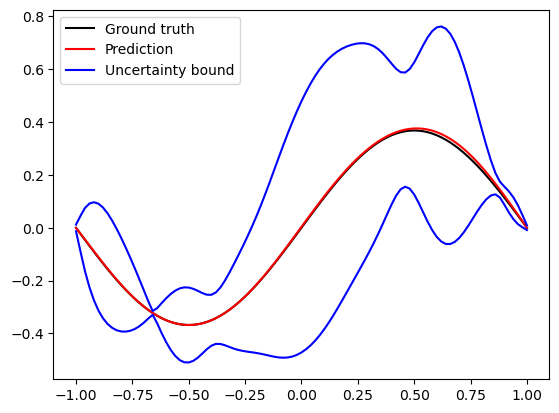

In [217]:
# plot
plt.style.use('default')
plt.figure()

plt.plot(x_t,reall,'k')
plt.plot(x_t,prediction,'r')
plt.plot(x_t,prediction+3*sigma,'b')


plt.legend(['Ground truth','Prediction','Uncertainty bound'], loc = 'best') 
plt.plot(x_t, prediction-3*sigma, 'b')